# Playing Atari with Deep Reinforcement Learning

Paper: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

Walkthorugh: https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec

# Imports

In [22]:
import numpy as np
import pandas as pd
import os
import gym
import time
import json
from copy import deepcopy

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from keras.utils.generic_utils import Progbar

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

from IPython import display
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18186548326210526545
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 432144384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17586047114927762776
physical_device_desc: "device: 0, name: GeForce GTX 650, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


# Environment

We use Gym's environments for now (specifically, the Atari environments).  Later, we'll be able to define our own environments using Gym's API, but for now we'll just use their out of the box options.

In the paper, they use the game `Breakout` with a slightly modified behavior that 'skips' every 4 frames.  It does this because they found that they didn't gain much improvement from having the DQN make an action for every frame, and instead found that having it make an action on every 4th frame (and just repeating that action for the 4 frames) was sufficient in this environment.  Gym offers this same version of the game, which can be made using `BreakoutDeterministic-v4`.

In [3]:
env = gym.make('BreakoutDeterministic-v4') # try out different envs
env.reset()

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Agent

In order to implement a DQN, we need to start with an agent.  Instead of writing one from scratch (which is more tedious than actually difficult), we're going to adapt code from the `keras-rl` library (https://github.com/keras-rl/keras-rl).  Their DQN implementation is designed to match the same one demonstrated in the paper.  I've looked through the code (at this point quite extensively), and it's implemented the same way we would, so it's quite suitable.

## Visualizer Callback

The keras-rl default visualizer is iffy when using a server so, we'll disable the default visualizer, and create a slightly modified version that suits our purposes.  Essentially, we just get the environment to return the image of the game as an RGB numpy array, then use Matplotlib to plot it.

Visualization should only be used for debugging/demonstration.  Using visualization during training will slow it down drastically, so use with caution.

In [4]:
class Visualizer(KerasCallback):
    def __init__(self, view_machine_mode=False, show_labels=True):
        self.machine_mode = view_machine_mode
        self.show_labels = show_labels
    
    def _set_env(self, env):
        self.env = env
        self.img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
        self.frame = 0
        plt.figure(figsize = (10,10))

    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        img = self.env.render(mode='rgb_array')
        
        if self.machine_mode:
            # This lines allow us to see what the NN sees
            img = img[::2, ::2] # downscale
            img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        
        self.frame += 1
        plt.cla()
        plt.imshow(img)
        if self.show_labels:
            plt.annotate('frame : ' + str(self.frame), xy=(10, 40), color='white')
            plt.annotate('action: ' + str(action), xy=(10, 50), color='white')
            
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Preprocessor

Since the environment is pre-built and the agent is pre-built, we create a keras-rl Processor to treat data according to the paper's specifications (downsample and grayscale).

Note: we could modify the environment, the agent, or both instead to do this if we needed, but keras-rl provides this API to be able to avoid that.

https://github.com/keras-rl/keras-rl/blob/master/rl/core.py

In [5]:
class AtariProcessor(Processor):      
    def process_observation(self, observation):
        # Normally, the observation is passed directly to the NN,
        # but we override this behavior to follow preprocessing steps
        img = observation 
        img = img[::2, ::2] # downscale
        img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        return img

## Model

This is the model used in the paper (or as close to it as I could get).  It's a pretty straight-forward CNN.  It implements the input's normalization as a `Lambda` layer (so that we don't have to preprocess the data in that respect).

The input is actually 4 Grayscale frames, hence the input shape of `(4, 105, 80)`.  This is how it was designed in the paper (it uses the 4 most recent frames so that the DQN can figure out things like the ball's trajectory).

We also don't directly compile the model.  The keras-rl library takes care of this for us, which is important since it handles 'special' properties of the model, such as using the **Huber Loss** and the output masking.  It should be noted that we could implement these things pretty readily in the model definition (as the walkthrough describes), but we don't since we're relying on keras-rl's implementation.

In [7]:
input_shape = (4, 105, 80)

frames_input = keras.layers.Input(input_shape, name='frames')

# performs normalization directly in model
normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)

conv_1 = keras.layers.Conv2D(16, (8,8), strides=(4, 4), activation='relu', data_format='channels_first')(normalized)
conv_2 = keras.layers.Conv2D(32, (4,4), strides=(2, 2), activation='relu')(conv_1)

conv_flattened = keras.layers.Flatten()(conv_2)
hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
output = keras.layers.Dense(nb_actions)(hidden)

model = keras.models.Model(inputs=frames_input, outputs=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
#model.compile(optimizer, loss='mse')

## Agent Creation

Finally, we put everything together to create the agent.  We need three things to actually create the agent: it's memory, it's policy, and it's model.  We created the model above, and keras-rl provides us with suitable classes for memory and policy.

The memory we'll be using is `Sequential Memory`, which works as described in the paper.  Note that we're using a `window_length` of 4, to reflect the 4 frames of information we need as described before.

The policy we'll be using for training is `EpsGreedyQPolicy` setup with `LinearAnnealedPolicy`.  The `EpsGreedyPolicy` is the ε-Greedy policy as described in the paper (it chooses a random action with a proportionate frequency to ε).  The `LinearAnnealedPolicy` is a class wrapper that anneals the ε value in the ε-Greedy policy (as described in the paper).

Finally, we put all this together in an instance of the DQNAgent class.  We pass through all of it's components, then compile it.

In [8]:
memory = SequentialMemory(limit=100000, window_length=4)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 1., 0.1, 0.05, 100000)
dqn = DQNAgent(model=model, processor=AtariProcessor(), nb_actions=nb_actions, 
               memory=memory, nb_steps_warmup=50, target_model_update=1e-2, policy=policy, test_policy=policy)
dqn.compile(optimizer, metrics=['mse'])

# Training

Finally, we can train the thing.  As mentioned above, we can add the `Visualizer` callback to the `fit` method to plot the image and set `visualize` to `False`.  We set `action_repetition` to 4 so that the agent only acts on every 4th frame.  The model's `fit` method returns the training history, so we can look at that later by saving to the `hist` variable.

After training has completed, we save the weights of the model (note: this will overwrite previous models.  If you want to save previous models, either move them or save the new one to a different path).  We also save the history to a pickle file for later viewing.

In [ ]:
# Setup Callbacks
session_num = len(os.listdir('sessions')) + 1
train_name = 'dqn_v' + str(session_num)
session_path = "sessions/" + train_name + '/'
model_path = session_path + "weights/weights_{step}.hdf5"
log_path = session_path + "log.json"

if not os.path.exists(session_path + 'weights'):
    os.makedirs(session_path + 'weights')

with open(session_path + 'model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
model.save(session_path + 'model.h5')

callback_list = []
callback_list.append(TensorBoard(log_dir=session_path))
callback_list.append(ModelIntervalCheckpoint(model_path, 500))
callback_list.append(FileLogger(log_path, 500))
#callback_list.append(Visualizer())

# train the DQN
hist = dqn.fit(env, nb_steps=1000000, visualize=False, 
               action_repetition=4, callbacks=callback_list, verbose=2)

# After training is done, we save the final weights
dqn.save_weights(session_path + "weights.h5f", overwrite=True)
model.save(session_path + 'model.h5')

# and save the history to a csv
results = pd.DataFrame(hist.history)
results.to_csv(session_path +"hist.csv")

Training for 1000000 steps ...
    111/1000000: episode: 1, duration: 3.667s, episode steps: 111, steps per second: 30, episode reward: 7.000, mean reward: 0.063 [0.000, 1.000], mean action: 1.613 [0.000, 3.000], mean observation: 39.375 [0.000, 142.000], loss: 0.025738, mean_squared_error: 0.703315, mean_q: 0.997127, mean_eps: 0.999275
    202/1000000: episode: 2, duration: 5.450s, episode steps: 91, steps per second: 17, episode reward: 5.000, mean reward: 0.055 [0.000, 1.000], mean action: 1.374 [0.000, 3.000], mean observation: 39.490 [0.000, 142.000], loss: 0.021247, mean_squared_error: 0.707965, mean_q: 0.992970, mean_eps: 0.998596
    257/1000000: episode: 3, duration: 3.328s, episode steps: 55, steps per second: 17, episode reward: 2.000, mean reward: 0.036 [0.000, 1.000], mean action: 1.327 [0.000, 3.000], mean observation: 39.723 [0.000, 142.000], loss: 0.023454, mean_squared_error: 0.729596, mean_q: 1.007391, mean_eps: 0.997939
    347/1000000: episode: 4, duration: 5.347s, 

   1948/1000000: episode: 28, duration: 3.541s, episode steps: 61, steps per second: 17, episode reward: 2.000, mean reward: 0.033 [0.000, 1.000], mean action: 1.623 [0.000, 3.000], mean observation: 39.792 [0.000, 142.000], loss: 0.024097, mean_squared_error: 1.110860, mean_q: 1.240753, mean_eps: 0.982747
   2002/1000000: episode: 29, duration: 3.206s, episode steps: 54, steps per second: 17, episode reward: 1.000, mean reward: 0.019 [0.000, 1.000], mean action: 1.444 [0.000, 3.000], mean observation: 39.803 [0.000, 142.000], loss: 0.033732, mean_squared_error: 1.148533, mean_q: 1.260878, mean_eps: 0.982229
   2055/1000000: episode: 30, duration: 3.105s, episode steps: 53, steps per second: 17, episode reward: 1.000, mean reward: 0.019 [0.000, 1.000], mean action: 1.208 [0.000, 3.000], mean observation: 39.809 [0.000, 142.000], loss: 0.027564, mean_squared_error: 1.154498, mean_q: 1.261945, mean_eps: 0.981748
   2118/1000000: episode: 31, duration: 3.754s, episode steps: 63, steps per

   5718/1000000: episode: 86, duration: 3.746s, episode steps: 64, steps per second: 17, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 1.281 [0.000, 3.000], mean observation: 40.003 [0.000, 142.000], loss: 0.021747, mean_squared_error: 1.726803, mean_q: 1.500674, mean_eps: 0.948830
   5775/1000000: episode: 87, duration: 3.309s, episode steps: 57, steps per second: 17, episode reward: 3.000, mean reward: 0.053 [0.000, 1.000], mean action: 1.421 [0.000, 3.000], mean observation: 39.751 [0.000, 142.000], loss: 0.022211, mean_squared_error: 1.747485, mean_q: 1.511239, mean_eps: 0.948286
   5836/1000000: episode: 88, duration: 3.534s, episode steps: 61, steps per second: 17, episode reward: 2.000, mean reward: 0.033 [0.000, 1.000], mean action: 1.426 [0.000, 3.000], mean observation: 39.808 [0.000, 142.000], loss: 0.029034, mean_squared_error: 1.797203, mean_q: 1.532236, mean_eps: 0.947755
   5923/1000000: episode: 89, duration: 4.985s, episode steps: 87, steps per

   7493/1000000: episode: 113, duration: 4.736s, episode steps: 82, steps per second: 17, episode reward: 4.000, mean reward: 0.049 [0.000, 1.000], mean action: 1.732 [0.000, 3.000], mean observation: 39.644 [0.000, 142.000], loss: 0.018470, mean_squared_error: 1.763375, mean_q: 1.475343, mean_eps: 0.932936
   7536/1000000: episode: 114, duration: 2.552s, episode steps: 43, steps per second: 17, episode reward: 1.000, mean reward: 0.023 [0.000, 1.000], mean action: 1.349 [0.000, 3.000], mean observation: 39.876 [0.000, 142.000], loss: 0.026760, mean_squared_error: 1.744043, mean_q: 1.463005, mean_eps: 0.932374
   7602/1000000: episode: 115, duration: 3.847s, episode steps: 66, steps per second: 17, episode reward: 2.000, mean reward: 0.030 [0.000, 1.000], mean action: 1.591 [0.000, 3.000], mean observation: 39.681 [0.000, 142.000], loss: 0.018979, mean_squared_error: 1.720434, mean_q: 1.442710, mean_eps: 0.931883
   7666/1000000: episode: 116, duration: 3.741s, episode steps: 64, steps

   9166/1000000: episode: 140, duration: 2.928s, episode steps: 50, steps per second: 17, episode reward: 1.000, mean reward: 0.020 [0.000, 1.000], mean action: 1.640 [0.000, 3.000], mean observation: 39.903 [0.000, 142.000], loss: 0.018933, mean_squared_error: 1.731588, mean_q: 1.424895, mean_eps: 0.917736
   9220/1000000: episode: 141, duration: 3.133s, episode steps: 54, steps per second: 17, episode reward: 2.000, mean reward: 0.037 [0.000, 1.000], mean action: 1.407 [0.000, 3.000], mean observation: 39.781 [0.000, 142.000], loss: 0.021023, mean_squared_error: 1.773704, mean_q: 1.453913, mean_eps: 0.917267
   9268/1000000: episode: 142, duration: 2.798s, episode steps: 48, steps per second: 17, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 1.521 [0.000, 3.000], mean observation: 40.009 [0.000, 142.000], loss: 0.018493, mean_squared_error: 1.767211, mean_q: 1.437107, mean_eps: 0.916809
   9360/1000000: episode: 143, duration: 5.354s, episode steps: 92, steps

  10796/1000000: episode: 167, duration: 3.484s, episode steps: 59, steps per second: 17, episode reward: 1.000, mean reward: 0.017 [0.000, 1.000], mean action: 1.712 [0.000, 3.000], mean observation: 39.706 [0.000, 142.000], loss: 0.025101, mean_squared_error: 1.662686, mean_q: 1.384557, mean_eps: 0.903106
  10862/1000000: episode: 168, duration: 3.850s, episode steps: 66, steps per second: 17, episode reward: 2.000, mean reward: 0.030 [0.000, 1.000], mean action: 1.561 [0.000, 3.000], mean observation: 39.736 [0.000, 142.000], loss: 0.018231, mean_squared_error: 1.621836, mean_q: 1.351903, mean_eps: 0.902543
  10917/1000000: episode: 169, duration: 3.192s, episode steps: 55, steps per second: 17, episode reward: 2.000, mean reward: 0.036 [0.000, 1.000], mean action: 1.564 [0.000, 3.000], mean observation: 39.859 [0.000, 142.000], loss: 0.023339, mean_squared_error: 1.645287, mean_q: 1.360811, mean_eps: 0.901999
  10983/1000000: episode: 170, duration: 3.880s, episode steps: 66, steps

  12509/1000000: episode: 194, duration: 2.854s, episode steps: 49, steps per second: 17, episode reward: 1.000, mean reward: 0.020 [0.000, 1.000], mean action: 1.367 [0.000, 3.000], mean observation: 39.866 [0.000, 142.000], loss: 0.019528, mean_squared_error: 1.557102, mean_q: 1.317321, mean_eps: 0.887644
  12584/1000000: episode: 195, duration: 4.399s, episode steps: 75, steps per second: 17, episode reward: 4.000, mean reward: 0.053 [0.000, 1.000], mean action: 1.587 [0.000, 3.000], mean observation: 39.683 [0.000, 142.000], loss: 0.018497, mean_squared_error: 1.560937, mean_q: 1.325230, mean_eps: 0.887086
  12658/1000000: episode: 196, duration: 4.246s, episode steps: 74, steps per second: 17, episode reward: 3.000, mean reward: 0.041 [0.000, 1.000], mean action: 1.608 [0.000, 3.000], mean observation: 39.659 [0.000, 142.000], loss: 0.020425, mean_squared_error: 1.575842, mean_q: 1.330743, mean_eps: 0.886416
  12722/1000000: episode: 197, duration: 3.798s, episode steps: 64, steps

  14168/1000000: episode: 221, duration: 2.720s, episode steps: 45, steps per second: 17, episode reward: 1.000, mean reward: 0.022 [0.000, 1.000], mean action: 1.689 [0.000, 3.000], mean observation: 39.943 [0.000, 142.000], loss: 0.018698, mean_squared_error: 1.625353, mean_q: 1.354587, mean_eps: 0.872695
  14212/1000000: episode: 222, duration: 2.579s, episode steps: 44, steps per second: 17, episode reward: 1.000, mean reward: 0.023 [0.000, 1.000], mean action: 1.818 [0.000, 3.000], mean observation: 39.760 [0.000, 142.000], loss: 0.015722, mean_squared_error: 1.603762, mean_q: 1.336316, mean_eps: 0.872294
  14288/1000000: episode: 223, duration: 4.405s, episode steps: 76, steps per second: 17, episode reward: 3.000, mean reward: 0.039 [0.000, 1.000], mean action: 1.566 [0.000, 3.000], mean observation: 39.707 [0.000, 142.000], loss: 0.018333, mean_squared_error: 1.596703, mean_q: 1.331642, mean_eps: 0.871754
  14398/1000000: episode: 224, duration: 6.444s, episode steps: 110, step

  15932/1000000: episode: 248, duration: 3.640s, episode steps: 62, steps per second: 17, episode reward: 2.000, mean reward: 0.032 [0.000, 1.000], mean action: 1.677 [0.000, 3.000], mean observation: 39.711 [0.000, 142.000], loss: 0.017733, mean_squared_error: 1.942444, mean_q: 1.510332, mean_eps: 0.856896
  15993/1000000: episode: 249, duration: 3.602s, episode steps: 61, steps per second: 17, episode reward: 3.000, mean reward: 0.049 [0.000, 1.000], mean action: 1.426 [0.000, 3.000], mean observation: 39.697 [0.000, 142.000], loss: 0.020201, mean_squared_error: 1.991469, mean_q: 1.537875, mean_eps: 0.856342
  16067/1000000: episode: 250, duration: 4.311s, episode steps: 74, steps per second: 17, episode reward: 4.000, mean reward: 0.054 [0.000, 1.000], mean action: 1.473 [0.000, 3.000], mean observation: 39.607 [0.000, 142.000], loss: 0.018631, mean_squared_error: 1.938443, mean_q: 1.511941, mean_eps: 0.855735
  16119/1000000: episode: 251, duration: 2.995s, episode steps: 52, steps

  17841/1000000: episode: 275, duration: 4.962s, episode steps: 84, steps per second: 17, episode reward: 3.000, mean reward: 0.036 [0.000, 1.000], mean action: 1.738 [0.000, 3.000], mean observation: 39.717 [0.000, 142.000], loss: 0.022000, mean_squared_error: 3.014738, mean_q: 1.915488, mean_eps: 0.839813
  17886/1000000: episode: 276, duration: 2.570s, episode steps: 45, steps per second: 18, episode reward: 1.000, mean reward: 0.022 [0.000, 1.000], mean action: 1.711 [0.000, 3.000], mean observation: 39.927 [0.000, 142.000], loss: 0.022961, mean_squared_error: 3.043151, mean_q: 1.930697, mean_eps: 0.839233
  17955/1000000: episode: 277, duration: 4.048s, episode steps: 69, steps per second: 17, episode reward: 3.000, mean reward: 0.043 [0.000, 1.000], mean action: 1.652 [0.000, 3.000], mean observation: 39.688 [0.000, 142.000], loss: 0.018540, mean_squared_error: 3.059907, mean_q: 1.933670, mean_eps: 0.838720
  18000/1000000: episode: 278, duration: 2.658s, episode steps: 45, steps

  19798/1000000: episode: 302, duration: 3.047s, episode steps: 52, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.750 [0.000, 3.000], mean observation: 39.855 [0.000, 142.000], loss: 0.019943, mean_squared_error: 4.124046, mean_q: 2.230671, mean_eps: 0.822056
  19871/1000000: episode: 303, duration: 4.301s, episode steps: 73, steps per second: 17, episode reward: 3.000, mean reward: 0.041 [0.000, 1.000], mean action: 1.630 [0.000, 3.000], mean observation: 39.694 [0.000, 142.000], loss: 0.019017, mean_squared_error: 4.146581, mean_q: 2.230917, mean_eps: 0.821494
  19948/1000000: episode: 304, duration: 4.533s, episode steps: 77, steps per second: 17, episode reward: 4.000, mean reward: 0.052 [0.000, 1.000], mean action: 1.636 [0.000, 3.000], mean observation: 39.622 [0.000, 142.000], loss: 0.021140, mean_squared_error: 4.173501, mean_q: 2.238537, mean_eps: 0.820819
  20031/1000000: episode: 305, duration: 4.895s, episode steps: 83, steps

  21703/1000000: episode: 329, duration: 4.033s, episode steps: 69, steps per second: 17, episode reward: 2.000, mean reward: 0.029 [0.000, 1.000], mean action: 1.551 [0.000, 3.000], mean observation: 39.902 [0.000, 142.000], loss: 0.021099, mean_squared_error: 4.871096, mean_q: 2.407959, mean_eps: 0.804988
  21765/1000000: episode: 330, duration: 3.623s, episode steps: 62, steps per second: 17, episode reward: 3.000, mean reward: 0.048 [0.000, 1.000], mean action: 1.613 [0.000, 3.000], mean observation: 39.718 [0.000, 142.000], loss: 0.025352, mean_squared_error: 4.956622, mean_q: 2.425260, mean_eps: 0.804399
  21824/1000000: episode: 331, duration: 3.531s, episode steps: 59, steps per second: 17, episode reward: 3.000, mean reward: 0.051 [0.000, 1.000], mean action: 1.627 [0.000, 3.000], mean observation: 39.720 [0.000, 142.000], loss: 0.021757, mean_squared_error: 4.802165, mean_q: 2.390705, mean_eps: 0.803854
  21890/1000000: episode: 332, duration: 3.825s, episode steps: 66, steps

  23579/1000000: episode: 356, duration: 3.810s, episode steps: 64, steps per second: 17, episode reward: 2.000, mean reward: 0.031 [0.000, 1.000], mean action: 1.641 [0.000, 3.000], mean observation: 39.714 [0.000, 142.000], loss: 0.020077, mean_squared_error: 5.327573, mean_q: 2.526491, mean_eps: 0.788081
  23646/1000000: episode: 357, duration: 3.924s, episode steps: 67, steps per second: 17, episode reward: 3.000, mean reward: 0.045 [0.000, 1.000], mean action: 1.507 [0.000, 3.000], mean observation: 39.767 [0.000, 142.000], loss: 0.023345, mean_squared_error: 5.060687, mean_q: 2.444200, mean_eps: 0.787492
  23717/1000000: episode: 358, duration: 4.117s, episode steps: 71, steps per second: 17, episode reward: 2.000, mean reward: 0.028 [0.000, 1.000], mean action: 1.676 [0.000, 3.000], mean observation: 39.737 [0.000, 142.000], loss: 0.020438, mean_squared_error: 5.338773, mean_q: 2.528362, mean_eps: 0.786871
  23773/1000000: episode: 359, duration: 3.263s, episode steps: 56, steps

  25545/1000000: episode: 383, duration: 2.664s, episode steps: 45, steps per second: 17, episode reward: 1.000, mean reward: 0.022 [0.000, 1.000], mean action: 1.578 [0.000, 3.000], mean observation: 39.867 [0.000, 142.000], loss: 0.021618, mean_squared_error: 5.682519, mean_q: 2.590624, mean_eps: 0.770302
  25608/1000000: episode: 384, duration: 3.718s, episode steps: 63, steps per second: 17, episode reward: 2.000, mean reward: 0.032 [0.000, 1.000], mean action: 1.508 [0.000, 3.000], mean observation: 39.748 [0.000, 142.000], loss: 0.025587, mean_squared_error: 5.622363, mean_q: 2.574962, mean_eps: 0.769816
  25661/1000000: episode: 385, duration: 3.055s, episode steps: 53, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.547 [0.000, 3.000], mean observation: 39.775 [0.000, 142.000], loss: 0.025161, mean_squared_error: 5.739607, mean_q: 2.605937, mean_eps: 0.769294
  25707/1000000: episode: 386, duration: 2.645s, episode steps: 46, steps

  27428/1000000: episode: 410, duration: 3.633s, episode steps: 62, steps per second: 17, episode reward: 3.000, mean reward: 0.048 [0.000, 1.000], mean action: 1.790 [0.000, 3.000], mean observation: 39.690 [0.000, 142.000], loss: 0.028638, mean_squared_error: 6.027587, mean_q: 2.690462, mean_eps: 0.753432
  27494/1000000: episode: 411, duration: 3.846s, episode steps: 66, steps per second: 17, episode reward: 2.000, mean reward: 0.030 [0.000, 1.000], mean action: 1.803 [0.000, 3.000], mean observation: 39.729 [0.000, 142.000], loss: 0.019670, mean_squared_error: 5.988749, mean_q: 2.681106, mean_eps: 0.752856
  27568/1000000: episode: 412, duration: 4.362s, episode steps: 74, steps per second: 17, episode reward: 4.000, mean reward: 0.054 [0.000, 1.000], mean action: 1.649 [0.000, 3.000], mean observation: 39.620 [0.000, 142.000], loss: 0.022032, mean_squared_error: 5.997611, mean_q: 2.678503, mean_eps: 0.752225
  27615/1000000: episode: 413, duration: 2.773s, episode steps: 47, steps

  29341/1000000: episode: 437, duration: 4.211s, episode steps: 73, steps per second: 17, episode reward: 8.000, mean reward: 0.110 [0.000, 4.000], mean action: 1.658 [0.000, 3.000], mean observation: 39.576 [0.000, 142.000], loss: 0.027940, mean_squared_error: 6.545693, mean_q: 2.787181, mean_eps: 0.736264
  29430/1000000: episode: 438, duration: 5.136s, episode steps: 89, steps per second: 17, episode reward: 7.000, mean reward: 0.079 [0.000, 4.000], mean action: 1.573 [0.000, 3.000], mean observation: 39.633 [0.000, 142.000], loss: 0.026267, mean_squared_error: 6.598003, mean_q: 2.797011, mean_eps: 0.735535
  29532/1000000: episode: 439, duration: 5.998s, episode steps: 102, steps per second: 17, episode reward: 5.000, mean reward: 0.049 [0.000, 1.000], mean action: 1.696 [0.000, 3.000], mean observation: 39.680 [0.000, 142.000], loss: 0.022002, mean_squared_error: 6.827913, mean_q: 2.862181, mean_eps: 0.734676
  29589/1000000: episode: 440, duration: 3.349s, episode steps: 57, step

  31314/1000000: episode: 464, duration: 3.486s, episode steps: 59, steps per second: 17, episode reward: 3.000, mean reward: 0.051 [0.000, 1.000], mean action: 1.932 [0.000, 3.000], mean observation: 39.763 [0.000, 142.000], loss: 0.021986, mean_squared_error: 6.853311, mean_q: 2.858088, mean_eps: 0.718444
  31392/1000000: episode: 465, duration: 4.481s, episode steps: 78, steps per second: 17, episode reward: 2.000, mean reward: 0.026 [0.000, 1.000], mean action: 1.654 [0.000, 3.000], mean observation: 39.846 [0.000, 142.000], loss: 0.027126, mean_squared_error: 6.954181, mean_q: 2.878358, mean_eps: 0.717827
  31465/1000000: episode: 466, duration: 4.242s, episode steps: 73, steps per second: 17, episode reward: 2.000, mean reward: 0.027 [0.000, 1.000], mean action: 1.671 [0.000, 3.000], mean observation: 39.888 [0.000, 142.000], loss: 0.027777, mean_squared_error: 7.125254, mean_q: 2.919529, mean_eps: 0.717148
  31511/1000000: episode: 467, duration: 2.727s, episode steps: 46, steps

  33226/1000000: episode: 491, duration: 3.133s, episode steps: 53, steps per second: 17, episode reward: 1.000, mean reward: 0.019 [0.000, 1.000], mean action: 1.377 [0.000, 3.000], mean observation: 39.784 [0.000, 142.000], loss: 0.020824, mean_squared_error: 7.573546, mean_q: 3.011580, mean_eps: 0.701209
  33311/1000000: episode: 492, duration: 5.022s, episode steps: 85, steps per second: 17, episode reward: 8.000, mean reward: 0.094 [0.000, 4.000], mean action: 1.659 [0.000, 3.000], mean observation: 39.606 [0.000, 142.000], loss: 0.031208, mean_squared_error: 7.521084, mean_q: 2.985803, mean_eps: 0.700588
  33375/1000000: episode: 493, duration: 3.734s, episode steps: 64, steps per second: 17, episode reward: 3.000, mean reward: 0.047 [0.000, 1.000], mean action: 1.734 [0.000, 3.000], mean observation: 39.697 [0.000, 142.000], loss: 0.025034, mean_squared_error: 7.472137, mean_q: 2.985579, mean_eps: 0.699917
  33427/1000000: episode: 494, duration: 3.006s, episode steps: 52, steps

  35149/1000000: episode: 518, duration: 5.635s, episode steps: 96, steps per second: 17, episode reward: 6.000, mean reward: 0.062 [0.000, 1.000], mean action: 1.625 [0.000, 3.000], mean observation: 39.517 [0.000, 142.000], loss: 0.034106, mean_squared_error: 7.961876, mean_q: 3.086145, mean_eps: 0.684095
  35205/1000000: episode: 519, duration: 3.336s, episode steps: 56, steps per second: 17, episode reward: 3.000, mean reward: 0.054 [0.000, 1.000], mean action: 1.161 [0.000, 3.000], mean observation: 39.719 [0.000, 142.000], loss: 0.024194, mean_squared_error: 7.907967, mean_q: 3.074132, mean_eps: 0.683412
  35308/1000000: episode: 520, duration: 6.065s, episode steps: 103, steps per second: 17, episode reward: 6.000, mean reward: 0.058 [0.000, 1.000], mean action: 1.515 [0.000, 3.000], mean observation: 39.481 [0.000, 142.000], loss: 0.029672, mean_squared_error: 7.928703, mean_q: 3.071667, mean_eps: 0.682696
  35378/1000000: episode: 521, duration: 4.078s, episode steps: 70, step

  37056/1000000: episode: 545, duration: 2.815s, episode steps: 48, steps per second: 17, episode reward: 1.000, mean reward: 0.021 [0.000, 1.000], mean action: 1.750 [0.000, 3.000], mean observation: 39.672 [0.000, 142.000], loss: 0.028707, mean_squared_error: 8.035435, mean_q: 3.111827, mean_eps: 0.666717
  37092/1000000: episode: 546, duration: 2.119s, episode steps: 36, steps per second: 17, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 1.528 [0.000, 3.000], mean observation: 40.001 [0.000, 142.000], loss: 0.028389, mean_squared_error: 8.215436, mean_q: 3.149593, mean_eps: 0.666338
  37148/1000000: episode: 547, duration: 3.307s, episode steps: 56, steps per second: 17, episode reward: 1.000, mean reward: 0.018 [0.000, 1.000], mean action: 1.875 [0.000, 3.000], mean observation: 39.731 [0.000, 142.000], loss: 0.031533, mean_squared_error: 8.103960, mean_q: 3.121374, mean_eps: 0.665925
  37212/1000000: episode: 548, duration: 3.684s, episode steps: 64, steps

  38770/1000000: episode: 572, duration: 3.393s, episode steps: 58, steps per second: 17, episode reward: 2.000, mean reward: 0.034 [0.000, 1.000], mean action: 1.534 [0.000, 3.000], mean observation: 39.744 [0.000, 142.000], loss: 0.035971, mean_squared_error: 8.648330, mean_q: 3.232991, mean_eps: 0.651335
  38854/1000000: episode: 573, duration: 4.850s, episode steps: 84, steps per second: 17, episode reward: 4.000, mean reward: 0.048 [0.000, 1.000], mean action: 1.488 [0.000, 3.000], mean observation: 39.714 [0.000, 142.000], loss: 0.031174, mean_squared_error: 8.542341, mean_q: 3.211730, mean_eps: 0.650696
  38936/1000000: episode: 574, duration: 4.829s, episode steps: 82, steps per second: 17, episode reward: 4.000, mean reward: 0.049 [0.000, 1.000], mean action: 1.634 [0.000, 3.000], mean observation: 39.627 [0.000, 142.000], loss: 0.031649, mean_squared_error: 8.663517, mean_q: 3.220312, mean_eps: 0.649949
  39021/1000000: episode: 575, duration: 4.883s, episode steps: 85, steps

  40652/1000000: episode: 599, duration: 4.017s, episode steps: 68, steps per second: 17, episode reward: 7.000, mean reward: 0.103 [0.000, 4.000], mean action: 1.662 [0.000, 3.000], mean observation: 39.622 [0.000, 142.000], loss: 0.034888, mean_squared_error: 8.527643, mean_q: 3.195626, mean_eps: 0.634442
  40794/1000000: episode: 600, duration: 8.120s, episode steps: 142, steps per second: 17, episode reward: 8.000, mean reward: 0.056 [0.000, 1.000], mean action: 1.641 [0.000, 3.000], mean observation: 39.399 [0.000, 142.000], loss: 0.024383, mean_squared_error: 8.747908, mean_q: 3.235961, mean_eps: 0.633498
  40866/1000000: episode: 601, duration: 4.175s, episode steps: 72, steps per second: 17, episode reward: 7.000, mean reward: 0.097 [0.000, 4.000], mean action: 1.667 [0.000, 3.000], mean observation: 39.677 [0.000, 142.000], loss: 0.025354, mean_squared_error: 8.942364, mean_q: 3.287360, mean_eps: 0.632534
  40938/1000000: episode: 602, duration: 4.215s, episode steps: 72, step

  42443/1000000: episode: 626, duration: 2.367s, episode steps: 40, steps per second: 17, episode reward: 1.000, mean reward: 0.025 [0.000, 1.000], mean action: 1.525 [0.000, 3.000], mean observation: 39.942 [0.000, 142.000], loss: 0.024424, mean_squared_error: 9.150969, mean_q: 3.324606, mean_eps: 0.618197
  42495/1000000: episode: 627, duration: 3.082s, episode steps: 52, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.500 [0.000, 3.000], mean observation: 39.744 [0.000, 142.000], loss: 0.032914, mean_squared_error: 9.201892, mean_q: 3.338452, mean_eps: 0.617783
  42567/1000000: episode: 628, duration: 4.212s, episode steps: 72, steps per second: 17, episode reward: 4.000, mean reward: 0.056 [0.000, 1.000], mean action: 1.556 [0.000, 3.000], mean observation: 39.651 [0.000, 142.000], loss: 0.025739, mean_squared_error: 9.060872, mean_q: 3.307341, mean_eps: 0.617225
  42633/1000000: episode: 629, duration: 3.795s, episode steps: 66, steps

  44246/1000000: episode: 653, duration: 5.555s, episode steps: 99, steps per second: 18, episode reward: 7.000, mean reward: 0.071 [0.000, 1.000], mean action: 1.485 [0.000, 3.000], mean observation: 39.458 [0.000, 142.000], loss: 0.023846, mean_squared_error: 9.449336, mean_q: 3.391929, mean_eps: 0.602236
  44319/1000000: episode: 654, duration: 4.265s, episode steps: 73, steps per second: 17, episode reward: 4.000, mean reward: 0.055 [0.000, 1.000], mean action: 1.726 [0.000, 3.000], mean observation: 39.632 [0.000, 142.000], loss: 0.026482, mean_squared_error: 9.321061, mean_q: 3.347380, mean_eps: 0.601462
  44370/1000000: episode: 655, duration: 2.997s, episode steps: 51, steps per second: 17, episode reward: 2.000, mean reward: 0.039 [0.000, 1.000], mean action: 1.471 [0.000, 3.000], mean observation: 39.807 [0.000, 142.000], loss: 0.026952, mean_squared_error: 9.411739, mean_q: 3.369028, mean_eps: 0.600904
  44431/1000000: episode: 656, duration: 3.460s, episode steps: 61, steps

  46009/1000000: episode: 680, duration: 3.585s, episode steps: 65, steps per second: 18, episode reward: 3.000, mean reward: 0.046 [0.000, 1.000], mean action: 1.846 [0.000, 3.000], mean observation: 39.691 [0.000, 142.000], loss: 0.024296, mean_squared_error: 9.225285, mean_q: 3.321355, mean_eps: 0.586216
  46048/1000000: episode: 681, duration: 2.246s, episode steps: 39, steps per second: 17, episode reward: 1.000, mean reward: 0.026 [0.000, 1.000], mean action: 1.359 [0.000, 3.000], mean observation: 39.868 [0.000, 142.000], loss: 0.031120, mean_squared_error: 9.613758, mean_q: 3.397930, mean_eps: 0.585748
  46108/1000000: episode: 682, duration: 3.446s, episode steps: 60, steps per second: 17, episode reward: 3.000, mean reward: 0.050 [0.000, 1.000], mean action: 1.500 [0.000, 3.000], mean observation: 39.810 [0.000, 142.000], loss: 0.022417, mean_squared_error: 9.317414, mean_q: 3.363034, mean_eps: 0.585302
  46148/1000000: episode: 683, duration: 2.398s, episode steps: 40, steps

  47796/1000000: episode: 707, duration: 4.514s, episode steps: 77, steps per second: 17, episode reward: 5.000, mean reward: 0.065 [0.000, 1.000], mean action: 1.649 [0.000, 3.000], mean observation: 39.553 [0.000, 142.000], loss: 0.024637, mean_squared_error: 9.384633, mean_q: 3.347305, mean_eps: 0.570187
  47867/1000000: episode: 708, duration: 4.160s, episode steps: 71, steps per second: 17, episode reward: 7.000, mean reward: 0.099 [0.000, 4.000], mean action: 1.423 [0.000, 3.000], mean observation: 39.636 [0.000, 142.000], loss: 0.022883, mean_squared_error: 9.809231, mean_q: 3.434125, mean_eps: 0.569521
  47903/1000000: episode: 709, duration: 2.186s, episode steps: 36, steps per second: 16, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 1.556 [0.000, 3.000], mean observation: 39.989 [0.000, 142.000], loss: 0.023497, mean_squared_error: 9.722389, mean_q: 3.416792, mean_eps: 0.569040
  47965/1000000: episode: 710, duration: 3.559s, episode steps: 62, steps

  49545/1000000: episode: 734, duration: 3.510s, episode steps: 59, steps per second: 17, episode reward: 2.000, mean reward: 0.034 [0.000, 1.000], mean action: 1.712 [0.000, 3.000], mean observation: 39.712 [0.000, 142.000], loss: 0.027665, mean_squared_error: 9.533026, mean_q: 3.378120, mean_eps: 0.554365
  49601/1000000: episode: 735, duration: 3.245s, episode steps: 56, steps per second: 17, episode reward: 3.000, mean reward: 0.054 [0.000, 1.000], mean action: 1.839 [0.000, 3.000], mean observation: 39.752 [0.000, 142.000], loss: 0.022333, mean_squared_error: 9.491480, mean_q: 3.365537, mean_eps: 0.553847
  49654/1000000: episode: 736, duration: 3.067s, episode steps: 53, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.736 [0.000, 3.000], mean observation: 39.815 [0.000, 142.000], loss: 0.028341, mean_squared_error: 9.448461, mean_q: 3.374371, mean_eps: 0.553357
  49705/1000000: episode: 737, duration: 3.021s, episode steps: 51, steps

  51266/1000000: episode: 761, duration: 2.738s, episode steps: 46, steps per second: 17, episode reward: 1.000, mean reward: 0.022 [0.000, 1.000], mean action: 1.674 [0.000, 3.000], mean observation: 39.968 [0.000, 142.000], loss: 0.018671, mean_squared_error: 9.751016, mean_q: 3.427230, mean_eps: 0.538817
  51376/1000000: episode: 762, duration: 6.422s, episode steps: 110, steps per second: 17, episode reward: 10.000, mean reward: 0.091 [0.000, 4.000], mean action: 1.555 [0.000, 3.000], mean observation: 39.403 [0.000, 142.000], loss: 0.026200, mean_squared_error: 9.571097, mean_q: 3.370174, mean_eps: 0.538115
  51435/1000000: episode: 763, duration: 3.433s, episode steps: 59, steps per second: 17, episode reward: 3.000, mean reward: 0.051 [0.000, 1.000], mean action: 1.831 [0.000, 3.000], mean observation: 39.711 [0.000, 142.000], loss: 0.019086, mean_squared_error: 9.745186, mean_q: 3.432001, mean_eps: 0.537355
  51523/1000000: episode: 764, duration: 5.242s, episode steps: 88, ste

  53175/1000000: episode: 788, duration: 5.553s, episode steps: 97, steps per second: 17, episode reward: 7.000, mean reward: 0.072 [0.000, 1.000], mean action: 1.629 [0.000, 3.000], mean observation: 39.421 [0.000, 142.000], loss: 0.026361, mean_squared_error: 9.588667, mean_q: 3.375672, mean_eps: 0.521866
  53263/1000000: episode: 789, duration: 5.051s, episode steps: 88, steps per second: 17, episode reward: 6.000, mean reward: 0.068 [0.000, 1.000], mean action: 1.545 [0.000, 3.000], mean observation: 39.522 [0.000, 142.000], loss: 0.025033, mean_squared_error: 9.807171, mean_q: 3.407275, mean_eps: 0.521033
  53301/1000000: episode: 790, duration: 2.274s, episode steps: 38, steps per second: 17, episode reward: 1.000, mean reward: 0.026 [0.000, 1.000], mean action: 1.526 [0.000, 3.000], mean observation: 39.746 [0.000, 142.000], loss: 0.018651, mean_squared_error: 9.859452, mean_q: 3.431975, mean_eps: 0.520466
  53378/1000000: episode: 791, duration: 4.451s, episode steps: 77, steps

  54942/1000000: episode: 815, duration: 3.923s, episode steps: 67, steps per second: 17, episode reward: 4.000, mean reward: 0.060 [0.000, 1.000], mean action: 1.657 [0.000, 3.000], mean observation: 39.647 [0.000, 142.000], loss: 0.020480, mean_squared_error: 10.186132, mean_q: 3.486117, mean_eps: 0.505828
  55037/1000000: episode: 816, duration: 5.523s, episode steps: 95, steps per second: 17, episode reward: 6.000, mean reward: 0.063 [0.000, 1.000], mean action: 1.716 [0.000, 3.000], mean observation: 39.517 [0.000, 142.000], loss: 0.025855, mean_squared_error: 9.950506, mean_q: 3.437284, mean_eps: 0.505099
  55106/1000000: episode: 817, duration: 4.044s, episode steps: 69, steps per second: 17, episode reward: 7.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.841 [0.000, 3.000], mean observation: 39.695 [0.000, 142.000], loss: 0.025162, mean_squared_error: 9.986598, mean_q: 3.448590, mean_eps: 0.504361
  55161/1000000: episode: 818, duration: 3.247s, episode steps: 55, step

  56894/1000000: episode: 842, duration: 3.864s, episode steps: 66, steps per second: 17, episode reward: 4.000, mean reward: 0.061 [0.000, 1.000], mean action: 1.939 [0.000, 3.000], mean observation: 39.645 [0.000, 142.000], loss: 0.021122, mean_squared_error: 10.801785, mean_q: 3.597953, mean_eps: 0.488256
  56963/1000000: episode: 843, duration: 4.073s, episode steps: 69, steps per second: 17, episode reward: 7.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.565 [0.000, 3.000], mean observation: 39.650 [0.000, 142.000], loss: 0.021862, mean_squared_error: 10.577893, mean_q: 3.543689, mean_eps: 0.487648
  57029/1000000: episode: 844, duration: 3.779s, episode steps: 66, steps per second: 17, episode reward: 7.000, mean reward: 0.106 [0.000, 4.000], mean action: 1.803 [0.000, 3.000], mean observation: 39.628 [0.000, 142.000], loss: 0.022704, mean_squared_error: 10.472168, mean_q: 3.537102, mean_eps: 0.487040
  57094/1000000: episode: 845, duration: 3.794s, episode steps: 65, st

  58825/1000000: episode: 869, duration: 3.405s, episode steps: 58, steps per second: 17, episode reward: 3.000, mean reward: 0.052 [0.000, 1.000], mean action: 1.862 [0.000, 3.000], mean observation: 39.685 [0.000, 142.000], loss: 0.022248, mean_squared_error: 10.999170, mean_q: 3.614929, mean_eps: 0.470840
  58922/1000000: episode: 870, duration: 5.692s, episode steps: 97, steps per second: 17, episode reward: 10.000, mean reward: 0.103 [0.000, 4.000], mean action: 1.753 [0.000, 3.000], mean observation: 39.416 [0.000, 142.000], loss: 0.021772, mean_squared_error: 11.084542, mean_q: 3.643129, mean_eps: 0.470143
  58981/1000000: episode: 871, duration: 3.481s, episode steps: 59, steps per second: 17, episode reward: 3.000, mean reward: 0.051 [0.000, 1.000], mean action: 1.831 [0.000, 3.000], mean observation: 39.688 [0.000, 142.000], loss: 0.025494, mean_squared_error: 11.364409, mean_q: 3.686292, mean_eps: 0.469441
  59080/1000000: episode: 872, duration: 5.741s, episode steps: 99, s

  60797/1000000: episode: 896, duration: 3.334s, episode steps: 57, steps per second: 17, episode reward: 3.000, mean reward: 0.053 [0.000, 1.000], mean action: 1.702 [0.000, 3.000], mean observation: 39.798 [0.000, 142.000], loss: 0.023130, mean_squared_error: 11.508604, mean_q: 3.701175, mean_eps: 0.453088
  60882/1000000: episode: 897, duration: 4.848s, episode steps: 85, steps per second: 18, episode reward: 9.000, mean reward: 0.106 [0.000, 4.000], mean action: 1.729 [0.000, 3.000], mean observation: 39.502 [0.000, 142.000], loss: 0.024031, mean_squared_error: 11.824450, mean_q: 3.769752, mean_eps: 0.452449
  60937/1000000: episode: 898, duration: 3.135s, episode steps: 55, steps per second: 18, episode reward: 3.000, mean reward: 0.055 [0.000, 1.000], mean action: 1.891 [0.000, 3.000], mean observation: 39.702 [0.000, 142.000], loss: 0.027368, mean_squared_error: 11.538199, mean_q: 3.709350, mean_eps: 0.451819
  61002/1000000: episode: 899, duration: 3.834s, episode steps: 65, st

  62739/1000000: episode: 923, duration: 3.125s, episode steps: 53, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.830 [0.000, 3.000], mean observation: 39.772 [0.000, 142.000], loss: 0.023801, mean_squared_error: 12.531870, mean_q: 3.884921, mean_eps: 0.435592
  62797/1000000: episode: 924, duration: 3.386s, episode steps: 58, steps per second: 17, episode reward: 2.000, mean reward: 0.034 [0.000, 1.000], mean action: 1.897 [0.000, 3.000], mean observation: 39.825 [0.000, 142.000], loss: 0.023833, mean_squared_error: 12.462458, mean_q: 3.860937, mean_eps: 0.435093
  62873/1000000: episode: 925, duration: 4.371s, episode steps: 76, steps per second: 17, episode reward: 5.000, mean reward: 0.066 [0.000, 1.000], mean action: 1.724 [0.000, 3.000], mean observation: 39.559 [0.000, 142.000], loss: 0.026643, mean_squared_error: 12.458872, mean_q: 3.862076, mean_eps: 0.434489
  62952/1000000: episode: 926, duration: 4.629s, episode steps: 79, st

  64716/1000000: episode: 950, duration: 3.850s, episode steps: 65, steps per second: 17, episode reward: 7.000, mean reward: 0.108 [0.000, 4.000], mean action: 1.938 [0.000, 3.000], mean observation: 39.619 [0.000, 142.000], loss: 0.023410, mean_squared_error: 13.106134, mean_q: 3.936756, mean_eps: 0.417853
  64788/1000000: episode: 951, duration: 4.153s, episode steps: 72, steps per second: 17, episode reward: 4.000, mean reward: 0.056 [0.000, 1.000], mean action: 1.694 [0.000, 3.000], mean observation: 39.626 [0.000, 142.000], loss: 0.023255, mean_squared_error: 13.219343, mean_q: 3.962187, mean_eps: 0.417237
  64853/1000000: episode: 952, duration: 3.853s, episode steps: 65, steps per second: 17, episode reward: 3.000, mean reward: 0.046 [0.000, 1.000], mean action: 1.892 [0.000, 3.000], mean observation: 39.690 [0.000, 142.000], loss: 0.022950, mean_squared_error: 13.470035, mean_q: 4.007677, mean_eps: 0.416620
  64947/1000000: episode: 953, duration: 5.520s, episode steps: 94, st

  66876/1000000: episode: 977, duration: 4.390s, episode steps: 76, steps per second: 17, episode reward: 8.000, mean reward: 0.105 [0.000, 4.000], mean action: 1.789 [0.000, 3.000], mean observation: 39.600 [0.000, 142.000], loss: 0.025095, mean_squared_error: 13.987188, mean_q: 4.084259, mean_eps: 0.398462
  66959/1000000: episode: 978, duration: 4.883s, episode steps: 83, steps per second: 17, episode reward: 5.000, mean reward: 0.060 [0.000, 1.000], mean action: 1.867 [0.000, 3.000], mean observation: 39.553 [0.000, 142.000], loss: 0.026710, mean_squared_error: 13.816541, mean_q: 4.054765, mean_eps: 0.397747
  67050/1000000: episode: 979, duration: 5.322s, episode steps: 91, steps per second: 17, episode reward: 6.000, mean reward: 0.066 [0.000, 1.000], mean action: 1.769 [0.000, 3.000], mean observation: 39.508 [0.000, 142.000], loss: 0.025948, mean_squared_error: 13.983990, mean_q: 4.083385, mean_eps: 0.396964
  67120/1000000: episode: 980, duration: 4.163s, episode steps: 70, st

  68844/1000000: episode: 1004, duration: 2.988s, episode steps: 51, steps per second: 17, episode reward: 2.000, mean reward: 0.039 [0.000, 1.000], mean action: 1.804 [0.000, 3.000], mean observation: 39.786 [0.000, 142.000], loss: 0.033597, mean_squared_error: 14.357020, mean_q: 4.117881, mean_eps: 0.380638
  68900/1000000: episode: 1005, duration: 3.253s, episode steps: 56, steps per second: 17, episode reward: 3.000, mean reward: 0.054 [0.000, 1.000], mean action: 1.821 [0.000, 3.000], mean observation: 39.699 [0.000, 142.000], loss: 0.040028, mean_squared_error: 14.265012, mean_q: 4.111021, mean_eps: 0.380157
  68987/1000000: episode: 1006, duration: 5.132s, episode steps: 87, steps per second: 17, episode reward: 9.000, mean reward: 0.103 [0.000, 4.000], mean action: 1.805 [0.000, 3.000], mean observation: 39.494 [0.000, 142.000], loss: 0.029233, mean_squared_error: 14.053481, mean_q: 4.059964, mean_eps: 0.379513
  69066/1000000: episode: 1007, duration: 4.680s, episode steps: 79

  70924/1000000: episode: 1031, duration: 4.945s, episode steps: 85, steps per second: 17, episode reward: 5.000, mean reward: 0.059 [0.000, 1.000], mean action: 1.906 [0.000, 3.000], mean observation: 39.557 [0.000, 142.000], loss: 0.024104, mean_squared_error: 15.231049, mean_q: 4.259349, mean_eps: 0.362071
  71028/1000000: episode: 1032, duration: 6.023s, episode steps: 104, steps per second: 17, episode reward: 7.000, mean reward: 0.067 [0.000, 1.000], mean action: 1.625 [0.000, 3.000], mean observation: 39.448 [0.000, 142.000], loss: 0.028091, mean_squared_error: 15.415435, mean_q: 4.298744, mean_eps: 0.361220
  71092/1000000: episode: 1033, duration: 3.782s, episode steps: 64, steps per second: 17, episode reward: 3.000, mean reward: 0.047 [0.000, 1.000], mean action: 1.766 [0.000, 3.000], mean observation: 39.679 [0.000, 142.000], loss: 0.023392, mean_squared_error: 15.076527, mean_q: 4.247051, mean_eps: 0.360464
  71145/1000000: episode: 1034, duration: 3.048s, episode steps: 5

  73161/1000000: episode: 1058, duration: 3.044s, episode steps: 52, steps per second: 17, episode reward: 2.000, mean reward: 0.038 [0.000, 1.000], mean action: 1.885 [0.000, 3.000], mean observation: 39.713 [0.000, 142.000], loss: 0.028165, mean_squared_error: 15.394287, mean_q: 4.282257, mean_eps: 0.341789
  73240/1000000: episode: 1059, duration: 4.662s, episode steps: 79, steps per second: 17, episode reward: 8.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.810 [0.000, 3.000], mean observation: 39.605 [0.000, 142.000], loss: 0.028231, mean_squared_error: 16.117578, mean_q: 4.393546, mean_eps: 0.341200
  73324/1000000: episode: 1060, duration: 4.903s, episode steps: 84, steps per second: 17, episode reward: 4.000, mean reward: 0.048 [0.000, 1.000], mean action: 1.869 [0.000, 3.000], mean observation: 39.611 [0.000, 142.000], loss: 0.025696, mean_squared_error: 15.895642, mean_q: 4.349559, mean_eps: 0.340467
  73412/1000000: episode: 1061, duration: 5.086s, episode steps: 88

  75318/1000000: episode: 1085, duration: 4.734s, episode steps: 81, steps per second: 17, episode reward: 5.000, mean reward: 0.062 [0.000, 1.000], mean action: 1.654 [0.000, 3.000], mean observation: 39.552 [0.000, 142.000], loss: 0.026797, mean_squared_error: 16.087572, mean_q: 4.386104, mean_eps: 0.322507
  75400/1000000: episode: 1086, duration: 4.798s, episode steps: 82, steps per second: 17, episode reward: 5.000, mean reward: 0.061 [0.000, 1.000], mean action: 1.695 [0.000, 3.000], mean observation: 39.539 [0.000, 142.000], loss: 0.024629, mean_squared_error: 16.369939, mean_q: 4.427107, mean_eps: 0.321773
  75485/1000000: episode: 1087, duration: 4.942s, episode steps: 85, steps per second: 17, episode reward: 9.000, mean reward: 0.106 [0.000, 4.000], mean action: 1.988 [0.000, 3.000], mean observation: 39.505 [0.000, 142.000], loss: 0.024528, mean_squared_error: 16.314042, mean_q: 4.422578, mean_eps: 0.321022
  75558/1000000: episode: 1088, duration: 4.220s, episode steps: 73

  77556/1000000: episode: 1112, duration: 3.609s, episode steps: 63, steps per second: 17, episode reward: 3.000, mean reward: 0.048 [0.000, 1.000], mean action: 2.032 [0.000, 3.000], mean observation: 39.686 [0.000, 142.000], loss: 0.026973, mean_squared_error: 16.783372, mean_q: 4.483533, mean_eps: 0.302284
  77644/1000000: episode: 1113, duration: 5.215s, episode steps: 88, steps per second: 17, episode reward: 6.000, mean reward: 0.068 [0.000, 1.000], mean action: 1.909 [0.000, 3.000], mean observation: 39.516 [0.000, 142.000], loss: 0.027890, mean_squared_error: 17.053667, mean_q: 4.530454, mean_eps: 0.301604
  77723/1000000: episode: 1114, duration: 4.672s, episode steps: 79, steps per second: 17, episode reward: 8.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.975 [0.000, 3.000], mean observation: 39.562 [0.000, 142.000], loss: 0.027140, mean_squared_error: 16.414195, mean_q: 4.378492, mean_eps: 0.300853
  77784/1000000: episode: 1115, duration: 3.429s, episode steps: 61

  79752/1000000: episode: 1139, duration: 4.685s, episode steps: 81, steps per second: 17, episode reward: 8.000, mean reward: 0.099 [0.000, 4.000], mean action: 1.963 [0.000, 3.000], mean observation: 39.559 [0.000, 142.000], loss: 0.025269, mean_squared_error: 17.233960, mean_q: 4.537260, mean_eps: 0.282601
  79850/1000000: episode: 1140, duration: 5.695s, episode steps: 98, steps per second: 17, episode reward: 7.000, mean reward: 0.071 [0.000, 1.000], mean action: 1.653 [0.000, 3.000], mean observation: 39.458 [0.000, 142.000], loss: 0.024571, mean_squared_error: 17.297284, mean_q: 4.538481, mean_eps: 0.281795
  79921/1000000: episode: 1141, duration: 4.074s, episode steps: 71, steps per second: 17, episode reward: 4.000, mean reward: 0.056 [0.000, 1.000], mean action: 1.817 [0.000, 3.000], mean observation: 39.700 [0.000, 142.000], loss: 0.030370, mean_squared_error: 17.247122, mean_q: 4.543705, mean_eps: 0.281035
  79991/1000000: episode: 1142, duration: 4.162s, episode steps: 70

  82045/1000000: episode: 1166, duration: 4.833s, episode steps: 84, steps per second: 17, episode reward: 5.000, mean reward: 0.060 [0.000, 1.000], mean action: 2.107 [0.000, 3.000], mean observation: 39.499 [0.000, 142.000], loss: 0.023357, mean_squared_error: 18.515723, mean_q: 4.743246, mean_eps: 0.261977
  82127/1000000: episode: 1167, duration: 4.805s, episode steps: 82, steps per second: 17, episode reward: 9.000, mean reward: 0.110 [0.000, 4.000], mean action: 2.061 [0.000, 3.000], mean observation: 39.520 [0.000, 142.000], loss: 0.028228, mean_squared_error: 18.442922, mean_q: 4.717307, mean_eps: 0.261230
  82231/1000000: episode: 1168, duration: 6.100s, episode steps: 104, steps per second: 17, episode reward: 9.000, mean reward: 0.087 [0.000, 4.000], mean action: 2.067 [0.000, 3.000], mean observation: 39.448 [0.000, 142.000], loss: 0.025004, mean_squared_error: 18.253530, mean_q: 4.696381, mean_eps: 0.260393
  82313/1000000: episode: 1169, duration: 4.775s, episode steps: 8

  84337/1000000: episode: 1193, duration: 4.415s, episode steps: 76, steps per second: 17, episode reward: 8.000, mean reward: 0.105 [0.000, 4.000], mean action: 1.658 [0.000, 3.000], mean observation: 39.539 [0.000, 142.000], loss: 0.032937, mean_squared_error: 19.593402, mean_q: 4.842492, mean_eps: 0.241313
  84446/1000000: episode: 1194, duration: 6.449s, episode steps: 109, steps per second: 17, episode reward: 11.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.862 [0.000, 3.000], mean observation: 39.275 [0.000, 142.000], loss: 0.025931, mean_squared_error: 19.251125, mean_q: 4.799543, mean_eps: 0.240481
  84511/1000000: episode: 1195, duration: 3.784s, episode steps: 65, steps per second: 17, episode reward: 4.000, mean reward: 0.062 [0.000, 1.000], mean action: 1.892 [0.000, 3.000], mean observation: 39.689 [0.000, 142.000], loss: 0.032182, mean_squared_error: 19.036627, mean_q: 4.766130, mean_eps: 0.239698
  84568/1000000: episode: 1196, duration: 3.287s, episode steps: 

  86599/1000000: episode: 1220, duration: 5.130s, episode steps: 90, steps per second: 18, episode reward: 13.000, mean reward: 0.144 [0.000, 4.000], mean action: 1.900 [0.000, 3.000], mean observation: 39.432 [0.000, 142.000], loss: 0.026692, mean_squared_error: 20.342355, mean_q: 4.926936, mean_eps: 0.221019
  86710/1000000: episode: 1221, duration: 6.372s, episode steps: 111, steps per second: 17, episode reward: 11.000, mean reward: 0.099 [0.000, 4.000], mean action: 2.018 [0.000, 3.000], mean observation: 39.306 [0.000, 142.000], loss: 0.024215, mean_squared_error: 20.443488, mean_q: 4.951489, mean_eps: 0.220114
  86805/1000000: episode: 1222, duration: 5.376s, episode steps: 95, steps per second: 18, episode reward: 13.000, mean reward: 0.137 [0.000, 4.000], mean action: 1.821 [0.000, 3.000], mean observation: 39.399 [0.000, 142.000], loss: 0.033706, mean_squared_error: 20.339958, mean_q: 4.933842, mean_eps: 0.219187
  86897/1000000: episode: 1223, duration: 5.352s, episode steps

  89129/1000000: episode: 1247, duration: 6.266s, episode steps: 108, steps per second: 17, episode reward: 11.000, mean reward: 0.102 [0.000, 4.000], mean action: 2.148 [0.000, 3.000], mean observation: 39.281 [0.000, 142.000], loss: 0.025269, mean_squared_error: 21.112983, mean_q: 5.034755, mean_eps: 0.198329
  89200/1000000: episode: 1248, duration: 4.149s, episode steps: 71, steps per second: 17, episode reward: 4.000, mean reward: 0.056 [0.000, 1.000], mean action: 1.859 [0.000, 3.000], mean observation: 39.631 [0.000, 142.000], loss: 0.030193, mean_squared_error: 21.055427, mean_q: 5.016177, mean_eps: 0.197524
  89325/1000000: episode: 1249, duration: 7.275s, episode steps: 125, steps per second: 17, episode reward: 15.000, mean reward: 0.120 [0.000, 4.000], mean action: 2.072 [0.000, 3.000], mean observation: 39.222 [0.000, 142.000], loss: 0.029761, mean_squared_error: 21.100034, mean_q: 5.030595, mean_eps: 0.196642
  89414/1000000: episode: 1250, duration: 5.220s, episode steps

  91666/1000000: episode: 1274, duration: 6.291s, episode steps: 109, steps per second: 17, episode reward: 14.000, mean reward: 0.128 [0.000, 4.000], mean action: 1.991 [0.000, 3.000], mean observation: 39.309 [0.000, 142.000], loss: 0.028023, mean_squared_error: 21.386158, mean_q: 5.051615, mean_eps: 0.175501
  91772/1000000: episode: 1275, duration: 6.013s, episode steps: 106, steps per second: 18, episode reward: 8.000, mean reward: 0.075 [0.000, 1.000], mean action: 1.755 [0.000, 3.000], mean observation: 39.291 [0.000, 142.000], loss: 0.031189, mean_squared_error: 21.357574, mean_q: 5.055067, mean_eps: 0.174534
  91891/1000000: episode: 1276, duration: 6.958s, episode steps: 119, steps per second: 17, episode reward: 12.000, mean reward: 0.101 [0.000, 4.000], mean action: 1.824 [0.000, 3.000], mean observation: 39.216 [0.000, 142.000], loss: 0.024636, mean_squared_error: 21.871317, mean_q: 5.121054, mean_eps: 0.173521
  91963/1000000: episode: 1277, duration: 4.212s, episode step

  94060/1000000: episode: 1301, duration: 4.988s, episode steps: 86, steps per second: 17, episode reward: 9.000, mean reward: 0.105 [0.000, 4.000], mean action: 1.872 [0.000, 3.000], mean observation: 39.467 [0.000, 142.000], loss: 0.026199, mean_squared_error: 23.049091, mean_q: 5.255681, mean_eps: 0.153852
  94162/1000000: episode: 1302, duration: 5.964s, episode steps: 102, steps per second: 17, episode reward: 13.000, mean reward: 0.127 [0.000, 4.000], mean action: 2.167 [0.000, 3.000], mean observation: 39.432 [0.000, 142.000], loss: 0.025158, mean_squared_error: 23.094445, mean_q: 5.278294, mean_eps: 0.153005
  94232/1000000: episode: 1303, duration: 4.080s, episode steps: 70, steps per second: 17, episode reward: 11.000, mean reward: 0.157 [0.000, 4.000], mean action: 1.929 [0.000, 3.000], mean observation: 39.544 [0.000, 142.000], loss: 0.025816, mean_squared_error: 23.105031, mean_q: 5.277189, mean_eps: 0.152231
  94342/1000000: episode: 1304, duration: 6.383s, episode steps:

  96445/1000000: episode: 1328, duration: 4.289s, episode steps: 74, steps per second: 17, episode reward: 8.000, mean reward: 0.108 [0.000, 4.000], mean action: 1.959 [0.000, 3.000], mean observation: 39.562 [0.000, 142.000], loss: 0.027379, mean_squared_error: 23.578450, mean_q: 5.327236, mean_eps: 0.132332
  96539/1000000: episode: 1329, duration: 5.394s, episode steps: 94, steps per second: 17, episode reward: 13.000, mean reward: 0.138 [0.000, 4.000], mean action: 1.862 [0.000, 3.000], mean observation: 39.408 [0.000, 142.000], loss: 0.026578, mean_squared_error: 23.846751, mean_q: 5.355601, mean_eps: 0.131576
  96632/1000000: episode: 1330, duration: 5.331s, episode steps: 93, steps per second: 17, episode reward: 13.000, mean reward: 0.140 [0.000, 4.000], mean action: 2.043 [0.000, 3.000], mean observation: 39.430 [0.000, 142.000], loss: 0.028084, mean_squared_error: 24.070963, mean_q: 5.387333, mean_eps: 0.130735
  96733/1000000: episode: 1331, duration: 5.932s, episode steps: 

  98861/1000000: episode: 1355, duration: 4.673s, episode steps: 82, steps per second: 18, episode reward: 12.000, mean reward: 0.146 [0.000, 4.000], mean action: 1.951 [0.000, 3.000], mean observation: 39.502 [0.000, 142.000], loss: 0.024970, mean_squared_error: 24.840837, mean_q: 5.492832, mean_eps: 0.110624
  98943/1000000: episode: 1356, duration: 4.712s, episode steps: 82, steps per second: 17, episode reward: 12.000, mean reward: 0.146 [0.000, 4.000], mean action: 1.988 [0.000, 3.000], mean observation: 39.518 [0.000, 142.000], loss: 0.027630, mean_squared_error: 24.721167, mean_q: 5.466335, mean_eps: 0.109886
  99050/1000000: episode: 1357, duration: 6.126s, episode steps: 107, steps per second: 17, episode reward: 7.000, mean reward: 0.065 [0.000, 1.000], mean action: 2.150 [0.000, 3.000], mean observation: 39.393 [0.000, 142.000], loss: 0.026972, mean_squared_error: 25.239382, mean_q: 5.530905, mean_eps: 0.109036
  99132/1000000: episode: 1358, duration: 4.772s, episode steps:

 101234/1000000: episode: 1382, duration: 6.196s, episode steps: 109, steps per second: 18, episode reward: 14.000, mean reward: 0.128 [0.000, 4.000], mean action: 1.917 [0.000, 3.000], mean observation: 39.342 [0.000, 142.000], loss: 0.030508, mean_squared_error: 26.048898, mean_q: 5.622448, mean_eps: 0.100000
 101303/1000000: episode: 1383, duration: 4.031s, episode steps: 69, steps per second: 17, episode reward: 11.000, mean reward: 0.159 [0.000, 4.000], mean action: 1.797 [0.000, 3.000], mean observation: 39.543 [0.000, 142.000], loss: 0.028943, mean_squared_error: 26.133599, mean_q: 5.611781, mean_eps: 0.100000
 101408/1000000: episode: 1384, duration: 6.103s, episode steps: 105, steps per second: 17, episode reward: 11.000, mean reward: 0.105 [0.000, 4.000], mean action: 2.105 [0.000, 3.000], mean observation: 39.307 [0.000, 142.000], loss: 0.029630, mean_squared_error: 26.396904, mean_q: 5.664710, mean_eps: 0.100000
 101489/1000000: episode: 1385, duration: 4.679s, episode step

 103745/1000000: episode: 1409, duration: 3.748s, episode steps: 65, steps per second: 17, episode reward: 7.000, mean reward: 0.108 [0.000, 4.000], mean action: 2.015 [0.000, 3.000], mean observation: 39.633 [0.000, 142.000], loss: 0.028259, mean_squared_error: 27.073283, mean_q: 5.748540, mean_eps: 0.100000
 103830/1000000: episode: 1410, duration: 4.879s, episode steps: 85, steps per second: 17, episode reward: 12.000, mean reward: 0.141 [0.000, 4.000], mean action: 1.976 [0.000, 3.000], mean observation: 39.511 [0.000, 142.000], loss: 0.026881, mean_squared_error: 27.252870, mean_q: 5.761135, mean_eps: 0.100000
 103934/1000000: episode: 1411, duration: 6.070s, episode steps: 104, steps per second: 17, episode reward: 14.000, mean reward: 0.135 [0.000, 4.000], mean action: 1.990 [0.000, 3.000], mean observation: 39.306 [0.000, 142.000], loss: 0.029466, mean_squared_error: 27.328943, mean_q: 5.744739, mean_eps: 0.100000
 104020/1000000: episode: 1412, duration: 4.990s, episode steps:

 106302/1000000: episode: 1436, duration: 5.714s, episode steps: 100, steps per second: 17, episode reward: 10.000, mean reward: 0.100 [0.000, 4.000], mean action: 1.890 [0.000, 3.000], mean observation: 39.373 [0.000, 142.000], loss: 0.024042, mean_squared_error: 27.940833, mean_q: 5.825455, mean_eps: 0.100000
 106391/1000000: episode: 1437, duration: 4.949s, episode steps: 89, steps per second: 18, episode reward: 13.000, mean reward: 0.146 [0.000, 4.000], mean action: 1.989 [0.000, 3.000], mean observation: 39.414 [0.000, 142.000], loss: 0.026897, mean_squared_error: 27.904599, mean_q: 5.825568, mean_eps: 0.100000
 106482/1000000: episode: 1438, duration: 5.227s, episode steps: 91, steps per second: 17, episode reward: 9.000, mean reward: 0.099 [0.000, 4.000], mean action: 1.560 [0.000, 3.000], mean observation: 39.500 [0.000, 142.000], loss: 0.030671, mean_squared_error: 28.103115, mean_q: 5.835249, mean_eps: 0.100000
 106578/1000000: episode: 1439, duration: 5.461s, episode steps:

 108758/1000000: episode: 1463, duration: 5.298s, episode steps: 91, steps per second: 17, episode reward: 13.000, mean reward: 0.143 [0.000, 4.000], mean action: 2.198 [0.000, 3.000], mean observation: 39.413 [0.000, 142.000], loss: 0.028036, mean_squared_error: 29.192451, mean_q: 5.976225, mean_eps: 0.100000
 108854/1000000: episode: 1464, duration: 5.664s, episode steps: 96, steps per second: 17, episode reward: 13.000, mean reward: 0.135 [0.000, 4.000], mean action: 1.927 [0.000, 3.000], mean observation: 39.447 [0.000, 142.000], loss: 0.027552, mean_squared_error: 29.522635, mean_q: 6.000774, mean_eps: 0.100000
 108949/1000000: episode: 1465, duration: 5.547s, episode steps: 95, steps per second: 17, episode reward: 13.000, mean reward: 0.137 [0.000, 4.000], mean action: 1.758 [0.000, 3.000], mean observation: 39.420 [0.000, 142.000], loss: 0.031982, mean_squared_error: 29.770968, mean_q: 6.024879, mean_eps: 0.100000
 109084/1000000: episode: 1466, duration: 7.795s, episode steps:

 111466/1000000: episode: 1490, duration: 4.478s, episode steps: 77, steps per second: 17, episode reward: 8.000, mean reward: 0.104 [0.000, 4.000], mean action: 2.117 [0.000, 3.000], mean observation: 39.537 [0.000, 142.000], loss: 0.022211, mean_squared_error: 31.057784, mean_q: 6.170374, mean_eps: 0.100000
 111549/1000000: episode: 1491, duration: 4.821s, episode steps: 83, steps per second: 17, episode reward: 5.000, mean reward: 0.060 [0.000, 1.000], mean action: 1.880 [0.000, 3.000], mean observation: 39.529 [0.000, 142.000], loss: 0.024797, mean_squared_error: 30.826218, mean_q: 6.154956, mean_eps: 0.100000
 111643/1000000: episode: 1492, duration: 5.443s, episode steps: 94, steps per second: 17, episode reward: 13.000, mean reward: 0.138 [0.000, 4.000], mean action: 2.096 [0.000, 3.000], mean observation: 39.419 [0.000, 142.000], loss: 0.025640, mean_squared_error: 31.314927, mean_q: 6.187617, mean_eps: 0.100000
 111737/1000000: episode: 1493, duration: 5.361s, episode steps: 9

 114150/1000000: episode: 1517, duration: 4.870s, episode steps: 84, steps per second: 17, episode reward: 12.000, mean reward: 0.143 [0.000, 4.000], mean action: 1.917 [0.000, 3.000], mean observation: 39.535 [0.000, 142.000], loss: 0.026602, mean_squared_error: 32.612580, mean_q: 6.326289, mean_eps: 0.100000
 114240/1000000: episode: 1518, duration: 5.203s, episode steps: 90, steps per second: 17, episode reward: 9.000, mean reward: 0.100 [0.000, 4.000], mean action: 2.111 [0.000, 3.000], mean observation: 39.496 [0.000, 142.000], loss: 0.031651, mean_squared_error: 32.213810, mean_q: 6.264502, mean_eps: 0.100000
 114361/1000000: episode: 1519, duration: 6.902s, episode steps: 121, steps per second: 18, episode reward: 16.000, mean reward: 0.132 [0.000, 4.000], mean action: 1.992 [0.000, 3.000], mean observation: 39.138 [0.000, 142.000], loss: 0.029979, mean_squared_error: 32.542220, mean_q: 6.312533, mean_eps: 0.100000
 114454/1000000: episode: 1520, duration: 5.286s, episode steps:

 116842/1000000: episode: 1544, duration: 6.485s, episode steps: 111, steps per second: 17, episode reward: 12.000, mean reward: 0.108 [0.000, 4.000], mean action: 2.117 [0.000, 3.000], mean observation: 39.226 [0.000, 142.000], loss: 0.030786, mean_squared_error: 33.077794, mean_q: 6.371768, mean_eps: 0.100000
 116952/1000000: episode: 1545, duration: 6.272s, episode steps: 110, steps per second: 18, episode reward: 12.000, mean reward: 0.109 [0.000, 4.000], mean action: 1.945 [0.000, 3.000], mean observation: 39.250 [0.000, 142.000], loss: 0.029142, mean_squared_error: 32.883564, mean_q: 6.362380, mean_eps: 0.100000
 117045/1000000: episode: 1546, duration: 5.360s, episode steps: 93, steps per second: 17, episode reward: 13.000, mean reward: 0.140 [0.000, 4.000], mean action: 2.054 [0.000, 3.000], mean observation: 39.430 [0.000, 142.000], loss: 0.027723, mean_squared_error: 32.482819, mean_q: 6.295470, mean_eps: 0.100000
 117174/1000000: episode: 1547, duration: 7.483s, episode step

 119750/1000000: episode: 1571, duration: 6.164s, episode steps: 106, steps per second: 17, episode reward: 14.000, mean reward: 0.132 [0.000, 4.000], mean action: 2.028 [0.000, 3.000], mean observation: 39.321 [0.000, 142.000], loss: 0.027910, mean_squared_error: 33.928171, mean_q: 6.462600, mean_eps: 0.100000
 119860/1000000: episode: 1572, duration: 6.332s, episode steps: 110, steps per second: 17, episode reward: 15.000, mean reward: 0.136 [0.000, 4.000], mean action: 2.055 [0.000, 3.000], mean observation: 39.287 [0.000, 142.000], loss: 0.028976, mean_squared_error: 33.844296, mean_q: 6.457121, mean_eps: 0.100000
 119944/1000000: episode: 1573, duration: 4.809s, episode steps: 84, steps per second: 17, episode reward: 9.000, mean reward: 0.107 [0.000, 4.000], mean action: 1.929 [0.000, 3.000], mean observation: 39.498 [0.000, 142.000], loss: 0.029179, mean_squared_error: 33.896387, mean_q: 6.434999, mean_eps: 0.100000
 120054/1000000: episode: 1574, duration: 6.355s, episode steps

 122524/1000000: episode: 1598, duration: 4.704s, episode steps: 83, steps per second: 18, episode reward: 9.000, mean reward: 0.108 [0.000, 4.000], mean action: 1.952 [0.000, 3.000], mean observation: 39.454 [0.000, 142.000], loss: 0.029187, mean_squared_error: 33.950316, mean_q: 6.437582, mean_eps: 0.100000
 122673/1000000: episode: 1599, duration: 8.570s, episode steps: 149, steps per second: 17, episode reward: 18.000, mean reward: 0.121 [0.000, 4.000], mean action: 2.101 [0.000, 3.000], mean observation: 39.022 [0.000, 142.000], loss: 0.029300, mean_squared_error: 34.829890, mean_q: 6.564733, mean_eps: 0.100000
 122769/1000000: episode: 1600, duration: 5.504s, episode steps: 96, steps per second: 17, episode reward: 10.000, mean reward: 0.104 [0.000, 4.000], mean action: 1.927 [0.000, 3.000], mean observation: 39.403 [0.000, 142.000], loss: 0.023375, mean_squared_error: 34.577370, mean_q: 6.515110, mean_eps: 0.100000
 122868/1000000: episode: 1601, duration: 5.640s, episode steps:

 125473/1000000: episode: 1625, duration: 6.136s, episode steps: 107, steps per second: 17, episode reward: 14.000, mean reward: 0.131 [0.000, 4.000], mean action: 1.907 [0.000, 3.000], mean observation: 39.319 [0.000, 142.000], loss: 0.033734, mean_squared_error: 34.477247, mean_q: 6.524874, mean_eps: 0.100000
 125585/1000000: episode: 1626, duration: 6.313s, episode steps: 112, steps per second: 18, episode reward: 12.000, mean reward: 0.107 [0.000, 4.000], mean action: 2.089 [0.000, 3.000], mean observation: 39.241 [0.000, 142.000], loss: 0.027148, mean_squared_error: 34.194235, mean_q: 6.465611, mean_eps: 0.100000
 125703/1000000: episode: 1627, duration: 6.762s, episode steps: 118, steps per second: 17, episode reward: 15.000, mean reward: 0.127 [0.000, 4.000], mean action: 1.881 [0.000, 3.000], mean observation: 39.184 [0.000, 142.000], loss: 0.026710, mean_squared_error: 34.851350, mean_q: 6.562823, mean_eps: 0.100000
 125856/1000000: episode: 1628, duration: 8.763s, episode ste

In [23]:
with open(log_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

# Testing

Here, we run the actual DQN in a test environment. There are a couple of things to note:

The `test` method doesn't necessarily use the same policy as the `fit` method.  It defaults to `GreedyQPolicy` unless `test_policy` in the `DQNAgent` instantiation is set.  If the model is properly trained, it's action might not vary at all given a greedy policy (e.g., it chooses `LEFT` for every action).  This isn't an issue (although it doesn't make for a very interesting training session), however, it can appear as the the session starts for a couple frames, then freezes.  This is actually because there is a `FIRE` action that the model must first take before the game starts.  If it's only going left, then the game never starts.  I added the 'frame' and 'action' labels to the visualization to check for this.

The `Visualization` callback needs to be added just like during training if you want to view it, and, similar to before, `visualize` needs to be set to `False` unless the system is properly configured to handle it.

Also similar to training, `action_repetition` is set to 4.  This is appropriate since this is how it was trained.

KeyboardInterrupt: 

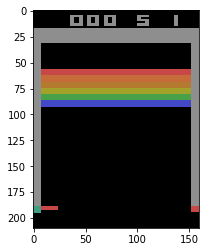

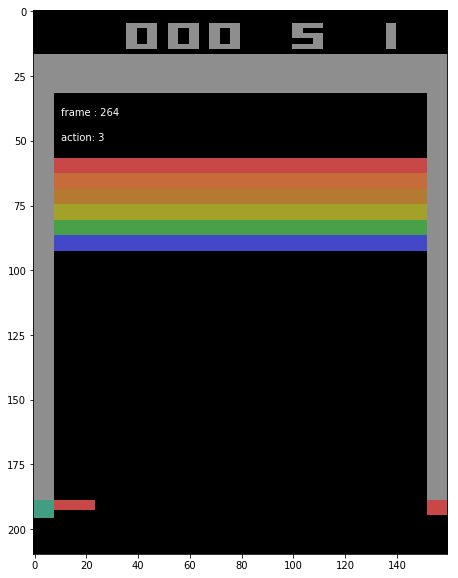

In [9]:
callbacks = []
callbacks = [Visualizer()]

test_hist = dqn.test(env, nb_episodes=1, action_repetition=4,
                     callbacks=callbacks, visualize=False)

# Results

After we have trained everything, we can look at the training history. We then plot the `episode_reward` to see how well it performed over each episode.

<IPython.core.display.Javascript object>


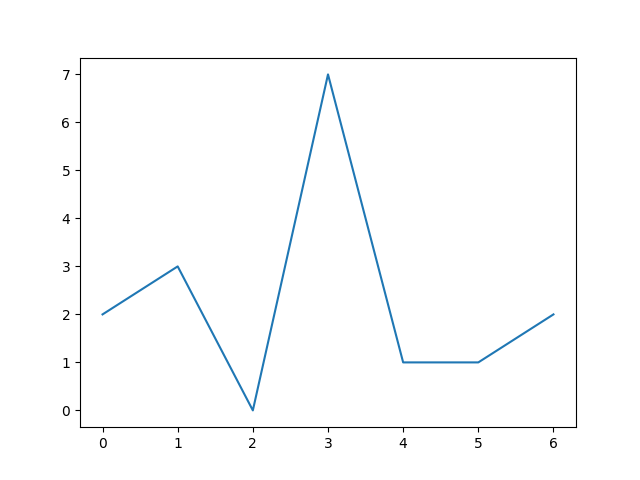

In [22]:
results = pd.read_pickle("sessions/" + train_name +"/hist.pickle")
plt.plot(results['episode_reward'])